<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Visualize-Conditions" data-toc-modified-id="Visualize-Conditions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Visualize Conditions</a></span></li><li><span><a href="#Sample-Training-Stimuli" data-toc-modified-id="Sample-Training-Stimuli-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sample Training Stimuli</a></span></li><li><span><a href="#Possible-Improvements" data-toc-modified-id="Possible-Improvements-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Possible Improvements</a></span></li><li><span><a href="#Run-Function-Learning-Task" data-toc-modified-id="Run-Function-Learning-Task-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Run Function-Learning Task</a></span></li><li><span><a href="#Save-Simulated-Data" data-toc-modified-id="Save-Simulated-Data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Save Simulated Data</a></span></li><li><span><a href="#Plot-Movements-in-Space" data-toc-modified-id="Plot-Movements-in-Space-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plot Movements in Space</a></span></li><li><span><a href="#True-y-Value-vs.-Size-of-Change" data-toc-modified-id="True-y-Value-vs.-Size-of-Change-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>True y Value vs. Size of Change</a></span></li><li><span><a href="#Local-Change-vs.-Size-of-Change" data-toc-modified-id="Local-Change-vs.-Size-of-Change-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Local Change vs. Size of Change</a></span></li><li><span><a href="#Prediction-Uncertainty-vs.-Size-of-Change" data-toc-modified-id="Prediction-Uncertainty-vs.-Size-of-Change-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Prediction Uncertainty vs. Size of Change</a></span></li><li><span><a href="#Summary-Function-Learning" data-toc-modified-id="Summary-Function-Learning-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Summary Function Learning</a></span></li><li><span><a href="#Correlations-Between-Movements-in-Different-Conditions" data-toc-modified-id="Correlations-Between-Movements-in-Different-Conditions-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Correlations Between Movements in Different Conditions</a></span></li><li><span><a href="#Plot-Changes-in-Uncertainty" data-toc-modified-id="Plot-Changes-in-Uncertainty-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Plot Changes in Uncertainty</a></span></li></ul></div>

In [1]:
from functools import reduce, partial
from itertools import repeat
from datetime import date
import sys
import multiprocessing
import pickle

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statsmodels.distributions import ECDF

sys.path.append("..")

In [2]:
# home-grown modules
import py_utils.utils as utils
import py_utils.plotting as plot_utils

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
plt.style.use("seaborn-whitegrid")
sns.set_style("whitegrid")

In [5]:
plt.style.use("presentation.mplstyle")

In [7]:
dict_variables = dict({
    "condition" : ["smooth", "rough"],
    "prior_sd" : [.25, 1],
    "sampling" : ["improvement"], # "metropolis-hastings", 
    "constrain_space" : [False],
    "space_edge_min" : [0],
    "space_edge_max" : [12],
    "n_features" : [2],
    "n_training" : [int(12**2/3)],
    "n_runs" : [200]
})

In [16]:
df_info, l_info, l_titles = utils.simulation_conditions(dict_variables, "function")

In [17]:
df_info

,condition,prior_sd,sampling,constrain_space,space_edge_min,space_edge_max,n_features,n_training,n_runs,length_scale
0,smooth,0.25,improvement,False,0,12,2,48,200,3
1,smooth,1.00,improvement,False,0,12,2,48,200,3
2,rough,0.25,improvement,False,0,12,2,48,200,1
3,rough,1.00,improvement,False,0,12,2,48,200,1


# Visualize Conditions

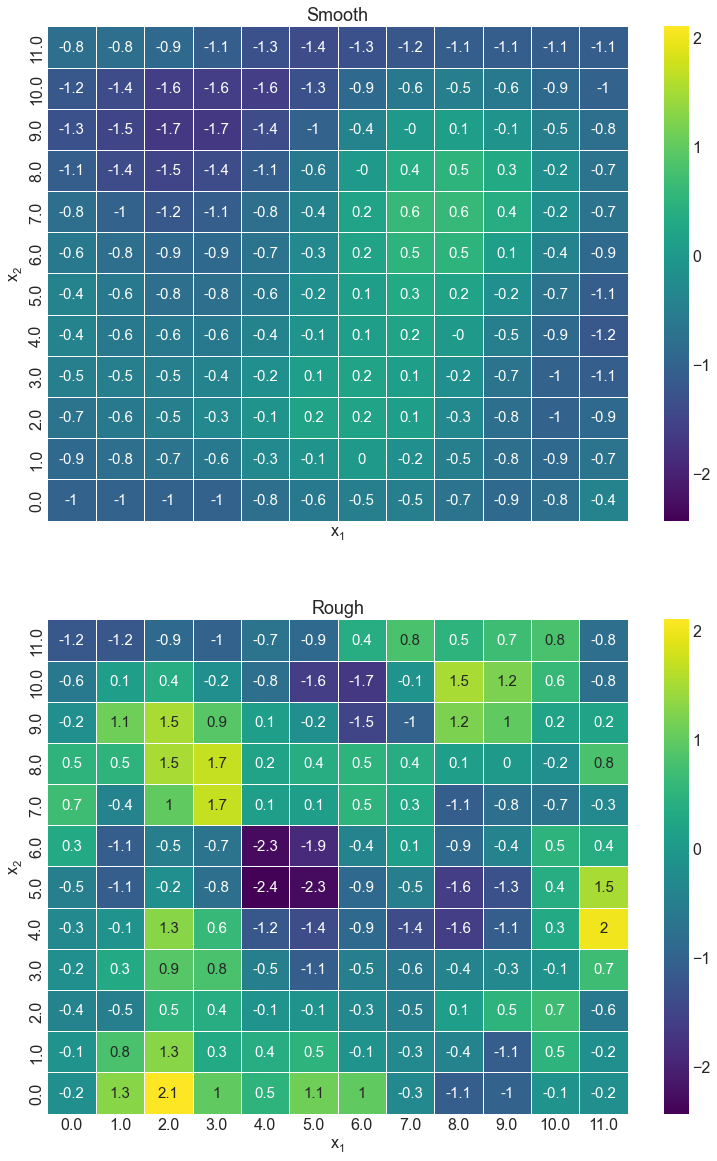

In [21]:
idxs=[0, len(l_info) - 1]
f, axes = plt.subplots(
    len(idxs), 1, sharex=True, sharey=True, figsize=(13, len(idxs) * 10)
)
plot_utils.plot_heatmaps(l_info, axes, idxs=idxs)

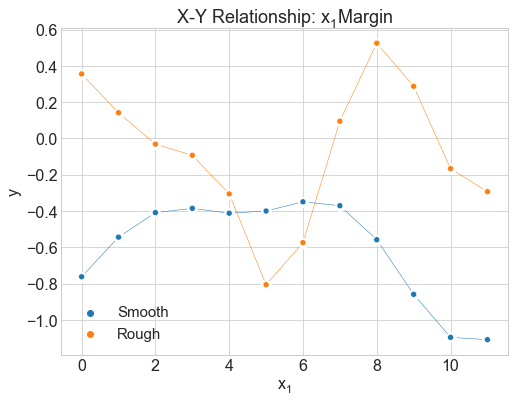

In [22]:
plt.style.use("presentation.mplstyle")
plot_utils.plot_1d_waves(l_info)

# Sample Training Stimuli

In [23]:
l_df_xy = list(map(utils.make_stimuli, l_info))

C:\Users\Mirko\AppData\Local\Temp/ipykernel_14272/3973477991.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


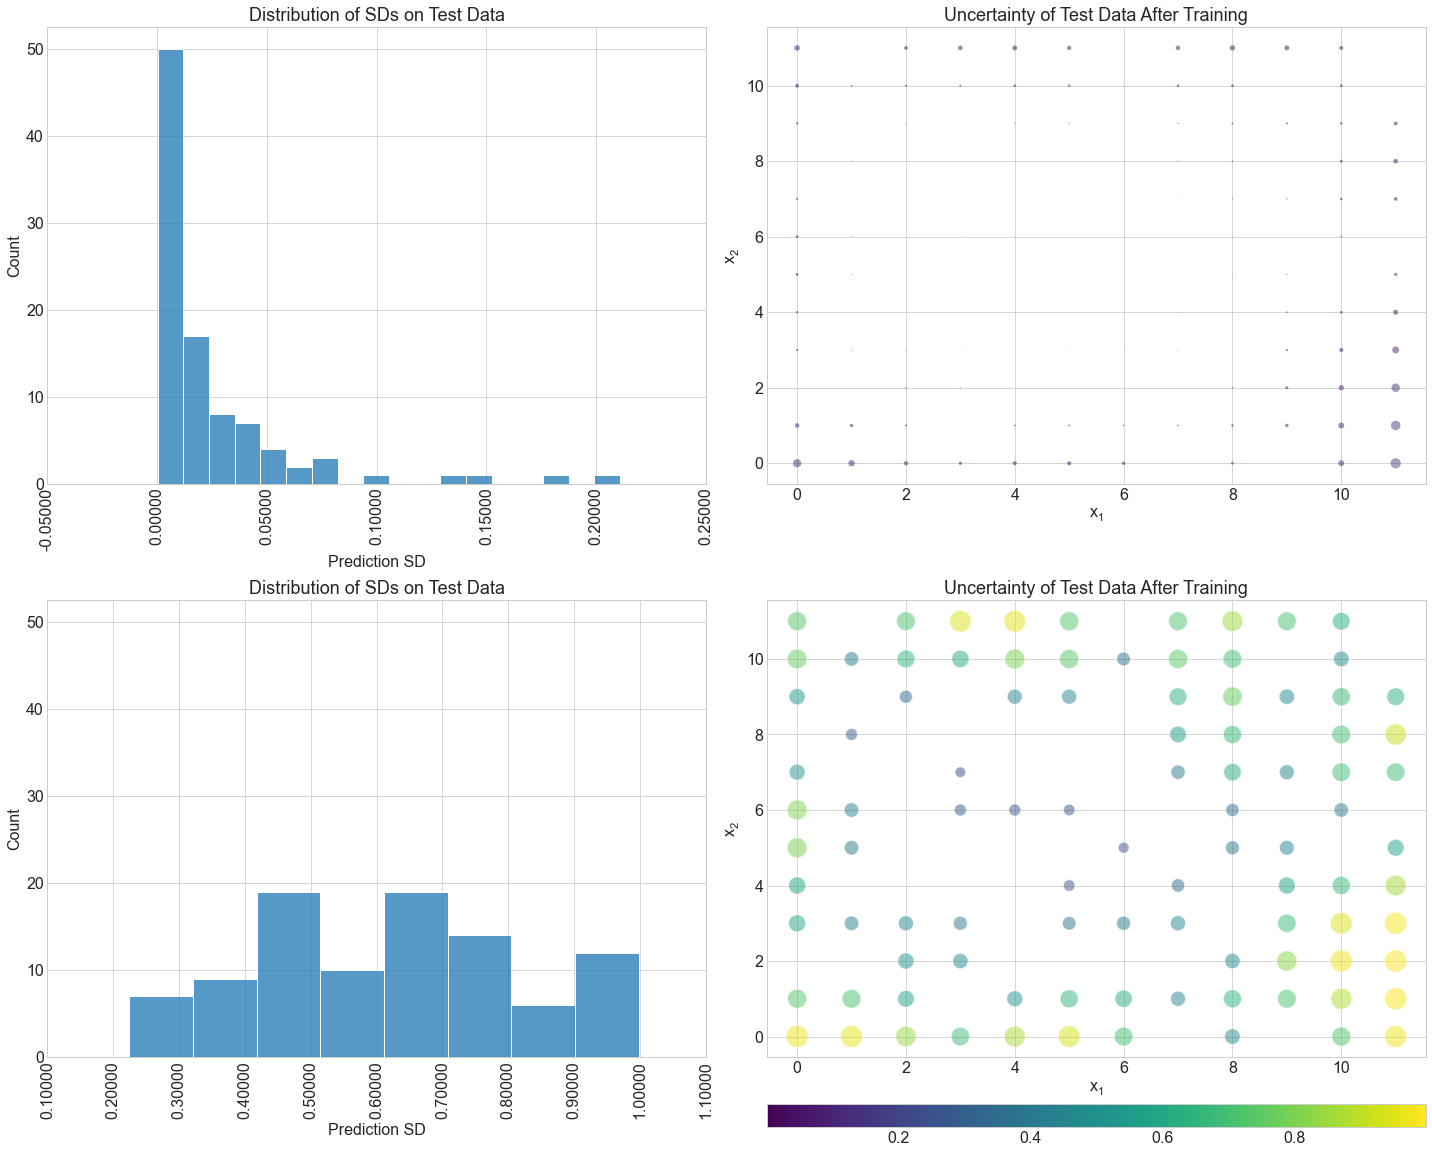

In [25]:
idx0 = 0
idx1 = len(l_info) - 1
float_formatter = "{:.5f}".format
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20, 16), sharex=False, sharey="col",
                  gridspec_kw={"height_ratios":[1, 1]})
axes_flat = axes.flatten()
l_df_xy[idx0], l_ivs, scaler = utils.scale_ivs(l_df_xy[idx0])
l_df_xy[idx1], l_ivs, scaler = utils.scale_ivs(l_df_xy[idx1])
df_train1, df_test1 = utils.split_train_test(l_info[idx0], l_df_xy[idx0])
df_train2, df_test2 = utils.split_train_test(l_info[idx1], l_df_xy[idx1])
# smooth
df_test1 = plot_utils.uncertainty_on_test_data(
    df_train1, df_test1, l_info[idx0], l_ivs
)
# rough
df_test2 = plot_utils.uncertainty_on_test_data(
    df_train2, df_test2, l_info[idx1], l_ivs
)
min_val = min(df_test1["y_pred_sd"].min(), df_test2["y_pred_sd"].min())
max_val = max(df_test1["y_pred_sd"].max(), df_test2["y_pred_sd"].max())

plot_utils.plot_uncertainty_on_test_data(df_test1, axes_flat[0:2], show_colorbar=False, min_val=min_val, max_val=max_val)
plot_utils.plot_uncertainty_on_test_data(df_test2, axes_flat[2:5], show_colorbar=False, min_val=min_val, max_val=max_val)


norm = plt.Normalize(
    min(df_test1["y_pred_sd"].min(), df_test2["y_pred_sd"].min()), 
    max(df_test1["y_pred_sd"].max(), df_test2["y_pred_sd"].max())
)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
axins = inset_axes(axes_flat[3],
                    width="100%",  
                    height="5%",
                    loc='lower center',
                    borderpad=-7
                   )
_ = fig.colorbar(sm, cax=axins, orientation="horizontal")
l_df_xy[idx0].drop([f"""{iv}_z""" for iv in l_ivs], axis=1, inplace=True)
l_df_xy[idx1].drop([f"""{iv}_z""" for iv in l_ivs], axis=1, inplace=True)

xt0 = [float_formatter(t) for t in axes_flat[0].get_xticks()]
axes_flat[0].xaxis.set_ticks([float(xv) for xv in xt0])
axes_flat[0].set_xticklabels(xt0, rotation=90)
xt2 = [float_formatter(t) for t in axes_flat[2].get_xticks()]
axes_flat[2].xaxis.set_ticks([float(xv) for xv in xt2])
_ = axes_flat[2].set_xticklabels(xt2, rotation=90)

plt.tight_layout()

Metropolis-Hastings Implementation
1. compare the y prediction error on the current trial to the distribution of expected deviations from y_pred_sd
2. uniformly sample a value between 0 and 1
3. accept the sample if that value is smaller than (1 - the ratio in 1).

# Run Function-Learning Task

In [26]:
n_cpus = min(len(l_info), multiprocessing.cpu_count() - 2)
p = multiprocessing.Pool(n_cpus)
#f_partial = partial(utils.run_perception, l_df_xy=l_df_xy)
# multiprocessing Pool map does not accept partial functions
list_perception = []
for x in tqdm(p.starmap(utils.run_perception, zip(l_info, l_df_xy))):
    list_perception.append(x)

  0%|          | 0/4 [00:00<?, ?it/s]

In [27]:
list_dfs_new = [l[0] for l in list_perception]
list_kernels = [l[1] for l in list_perception]

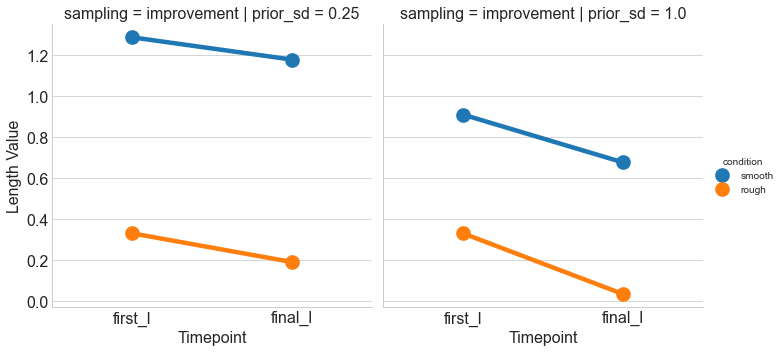

In [28]:
df_info["first_l"] = [k[0] for k in list_kernels]
df_info["final_l"] = [k[-1] for k in list_kernels]
df_length = df_info.groupby(["condition", "prior_sd", "sampling"])[["first_l", "final_l"]].mean().reset_index()
df_length = df_length.melt(
    id_vars=["condition", "prior_sd", "sampling"], 
    value_vars=["first_l", "final_l"],
    var_name="Timepoint",
    value_name="Length Value"
)
_ = sns.catplot(
    x="Timepoint", y="Length Value", hue="condition", 
    row="sampling", col="prior_sd", kind="point", scale=5,
    data=df_length
)

# Save Simulated Data

In [29]:
str_today = str(date.today())

with open(f"""../data/{str_today}-refit-gp-more-prior-sds.pickle""", "wb") as f:
    pickle.dump(list_dfs_new, f)

with open(f"""../data/{str_today}-refit-gp.pickle""", "rb") as f:
    list_dfs_new = pickle.load(f)

- think about leaving in prior points when plotting movements (prior & likelihood...) as I did that in the category learning part

# Plot Movements in Space

In [30]:
df_info

,condition,prior_sd,sampling,constrain_space,space_edge_min,space_edge_max,n_features,n_training,n_runs,length_scale,first_l,final_l
0,smooth,0.25,improvement,False,0,12,2,48,200,3,1.284971,1.176301
1,smooth,1.00,improvement,False,0,12,2,48,200,3,0.908611,0.675607
2,rough,0.25,improvement,False,0,12,2,48,200,1,0.330451,0.190448
3,rough,1.00,improvement,False,0,12,2,48,200,1,0.330451,0.034479


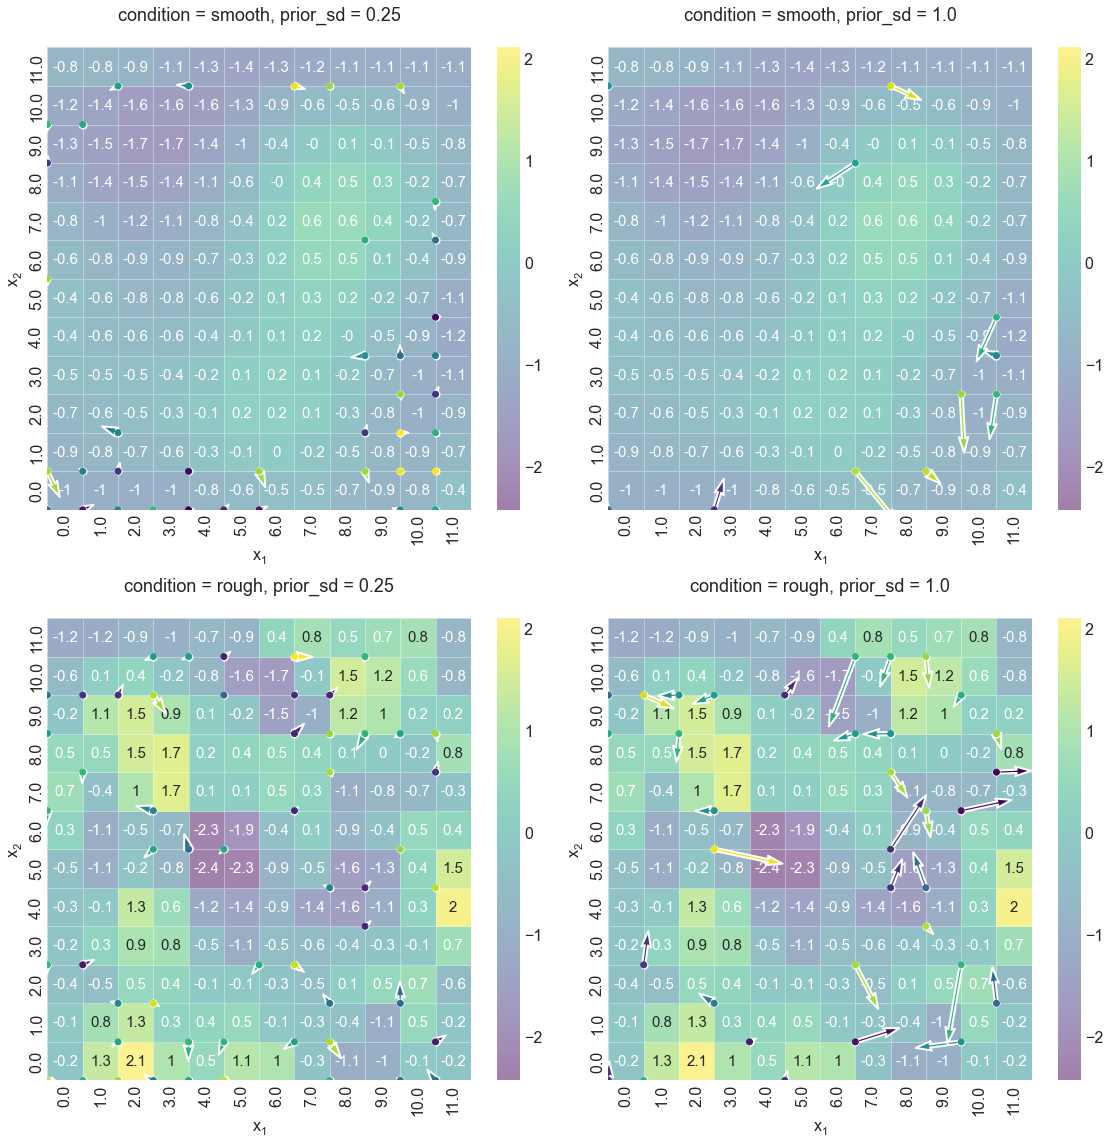

In [33]:
f_partial = partial(plot_utils.plot_moves_one_condition, list_dfs_new=list_dfs_new, df_info=df_info)
slices = slice(0, 4)
l_idxs = df_info.index[slices].to_list()
f, axes = plt.subplots(2, 2, figsize=(16, 16))
_ = list(map(f_partial, l_idxs, l_titles[slices], axes.flatten()))
plot_utils.plot_heatmaps(l_info, axes.flat, l_idxs, l_titles=l_titles[slices], alpha=.5)
plt.tight_layout()
# plt.savefig(f"""../figures/{str_today}-func-learning-smooth-movements-refit.png""")

# True y Value vs. Size of Change

In [34]:
list_dfs_new = list(map(utils.add_max_gradient, tqdm(list_dfs_new)))

  0%|          | 0/4 [00:00<?, ?it/s]

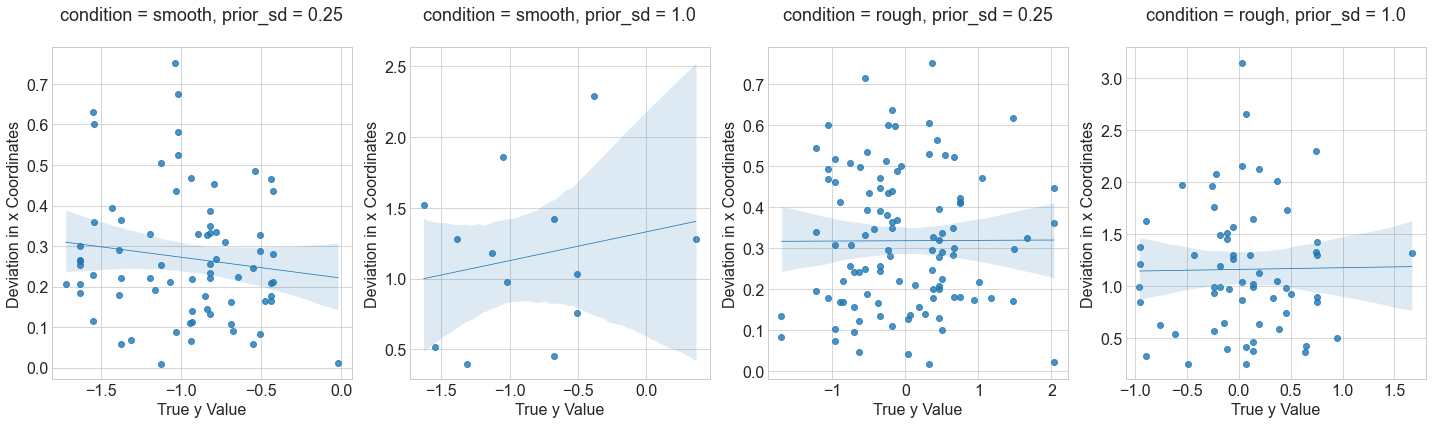

In [36]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
axes_flat = axes.flatten()
_ = list(map(plot_utils.regplot_y, list_dfs_new, l_titles, axes_flat))
plt.tight_layout()

# Local Change vs. Size of Change

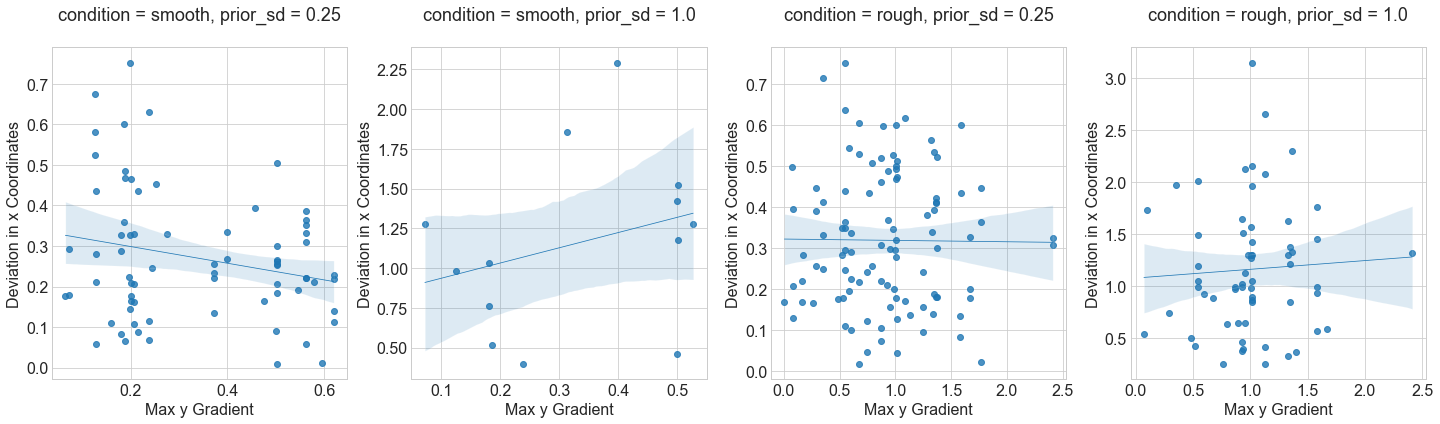

In [37]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
axes_flat = axes.flatten()
_ = list(map(plot_utils.regplot_max_gradient, list_dfs_new, l_titles, axes_flat))
plt.tight_layout()

# Prediction Uncertainty vs. Size of Change

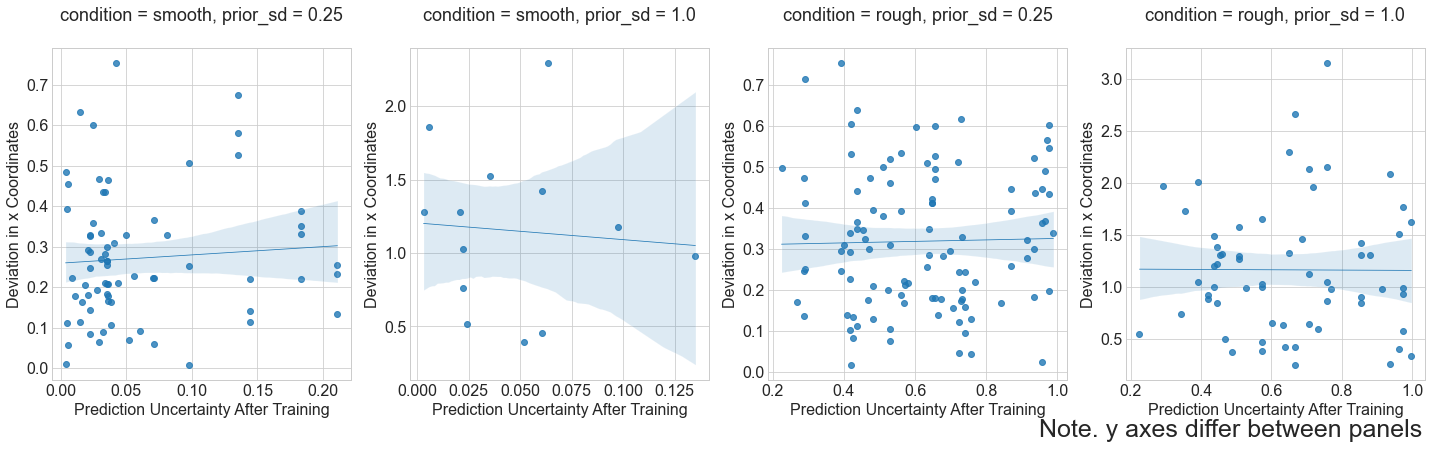

In [38]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
axes_flat = axes.flatten()
_ = list(map(plot_utils.regplot_start_uncertainty, list_dfs_new, l_titles, axes_flat))
plt.tight_layout()
str_note = "Note. y axes differ between panels"
_ = plt.figtext(0.99, -0.02, str_note, horizontalalignment='right', size=25)

# Summary Function Learning
- After training, more information is still required when people are in the rough condition compared to smooth condition
    - i.e., people are more likely to accept samples in the rough condition
    - overall movement of representations in space should be larger
- how about metropolis-hasting algorithm? why is there no reduction in uncertainty?

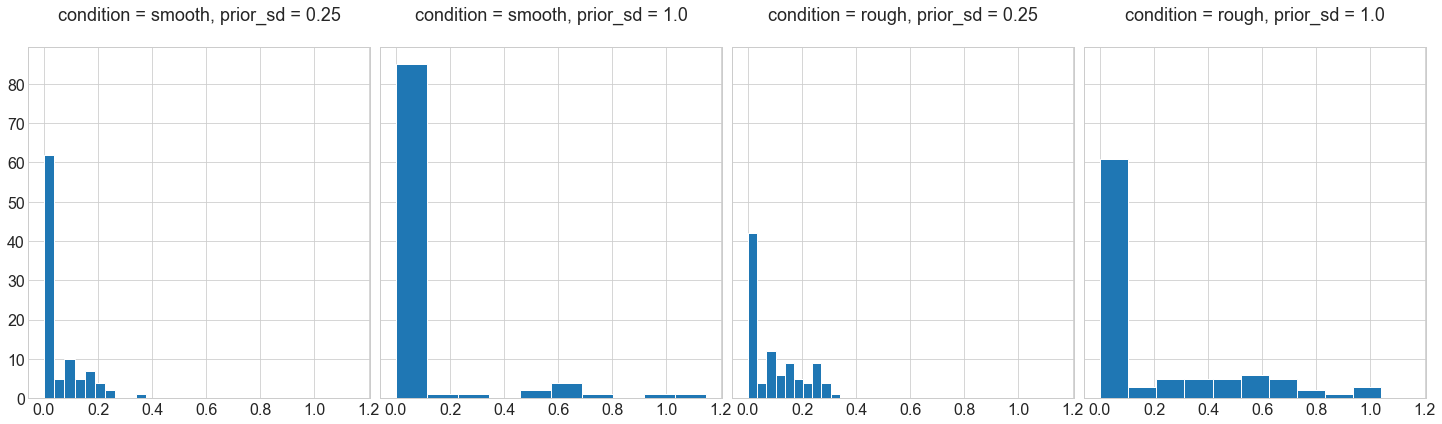

In [40]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharex=True, sharey=True)
axes_flat = axes.flatten()
_ = list(map(plot_utils.plot_movement_lengths, list_dfs_new, l_titles, axes_flat))
plt.tight_layout()

# Correlations Between Movements in Different Conditions

In [41]:
l_df_movements = list(map(utils.add_angle_of_movements, list_dfs_new))

In [42]:
df1 = pd.Series(range(len(l_df_movements)), name="Condition 1")
df2 = pd.Series(range(len(l_df_movements)), name="Condition 2")
df_cross = pd.merge(df1, df2, how="cross")
f_partial = partial(plot_utils.correlation_between_movement_angles, l_df_movements = l_df_movements)
df_cross["correlation"] = list(map(f_partial, df_cross["Condition 1"].to_list(), df_cross["Condition 2"].to_list()))

In [43]:
filt_info = (df_info["constrain_space"] == False)#(df_info["prior_sd"] == 1)# & 
idxs_required = df_info.loc[filt_info].index.to_list()#
filt = (df_cross["Condition 1"].isin(idxs_required)) & (df_cross["Condition 2"].isin(idxs_required))
df_cross = df_cross.loc[filt, ].copy()

In [44]:
df_cross["corr_above_0"] = df_cross["correlation"] > 0
prop_above_0 = (
    df_cross.query("`Condition 1` != `Condition 2`")["corr_above_0"].sum() / 
    df_cross.query("`Condition 1` != `Condition 2`").shape[0]
).round(2)
print("Proportion of Correlations > 0 between Movement Directions in Simulation Conditions: ", prop_above_0)

Proportion of Correlations > 0 between Movement Directions in Simulation Conditions:  0.83


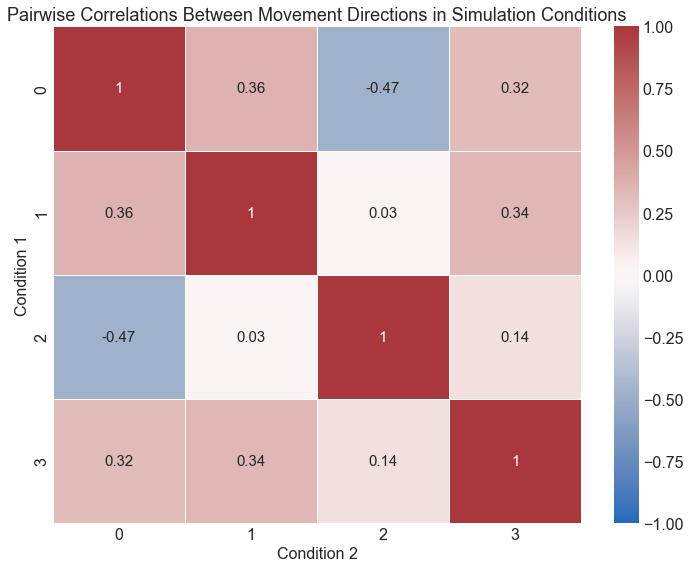

In [45]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(
    df_cross.pivot(index="Condition 1", columns="Condition 2", values="correlation").round(2), 
    annot=True, annot_kws={"size":15}, linewidths=1, cmap="vlag", vmin = -1, vmax = 1, ax=ax
)
_ = ax.set_title("Pairwise Correlations Between Movement Directions in Simulation Conditions")
plt.tight_layout()
# plt.savefig(f"""../figures/{str_today}-func-learning-pairwise-correlations-constrained-refit.png""")

# Plot Changes in Uncertainty

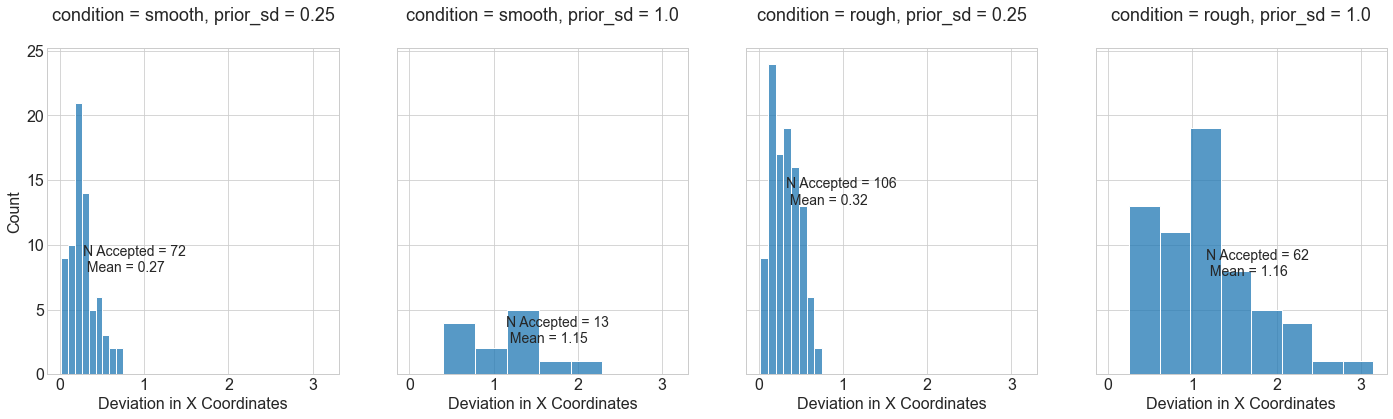

In [63]:
stim_id = 133 # but then 132 shows opposite pattern
l_idxs = range(0, 4)
n_plots = len(l_idxs)
n_cols = 4
n_rows = int(np.ceil(n_plots / n_cols))
f, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*6), sharex=True, sharey=True)
_ = plot_utils.plot_gp_deviations(axes, l_idxs, list_dfs_new, l_titles) # , stim_id
#plt.suptitle("Model Deviation from True Points after Testing Period\n", size=20)
# plt.tight_layout()

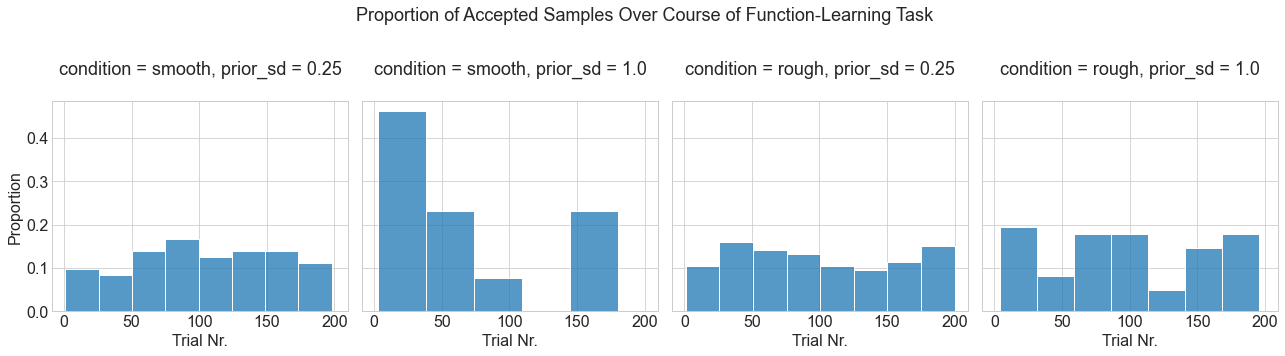

In [58]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharex=True, sharey=True)
f_partial = partial(plot_utils.plot_proportion_accepted_samples, n_runs=l_info[0]["n_runs"])
list(map(f_partial, list_dfs_new, l_titles, axes.flatten()))
_ = fig.suptitle("Proportion of Accepted Samples Over Course of Function-Learning Task\n")
plt.tight_layout()

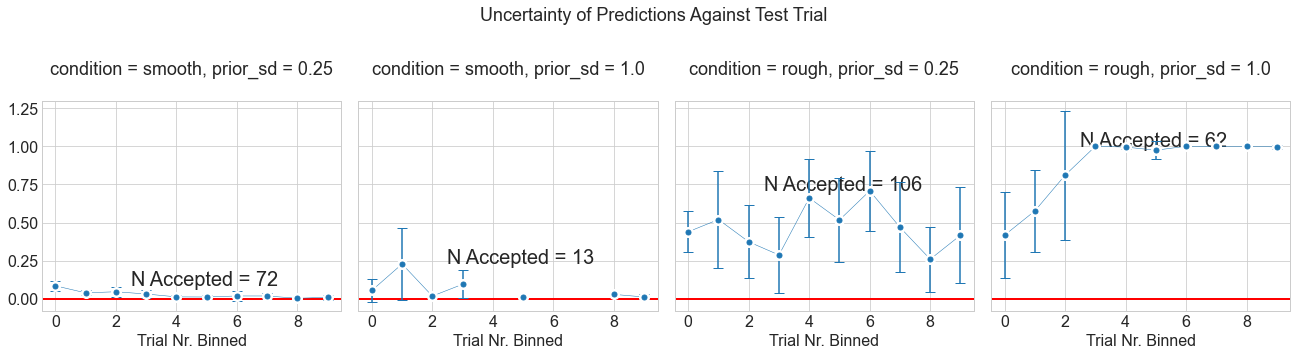

In [59]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharex=True, sharey=True)
plot_uncertainty_over_test_partial = partial(plot_utils.plot_var_over_bintime, var="y_pred_sd")
list(map(plot_uncertainty_over_test_partial, list_dfs_new, l_titles, axes.flatten()))
_ = fig.suptitle("Uncertainty of Predictions Against Test Trial\n")
plt.tight_layout()
str_note = "Note. y axes differ between panels"
# _ = plt.figtext(0.99, -0.02, str_note, horizontalalignment='right', size=25)

In [61]:
for i in list_dfs_new:
    i["r_sq"] = (i["y"] - i["y_pred_mn"])**2

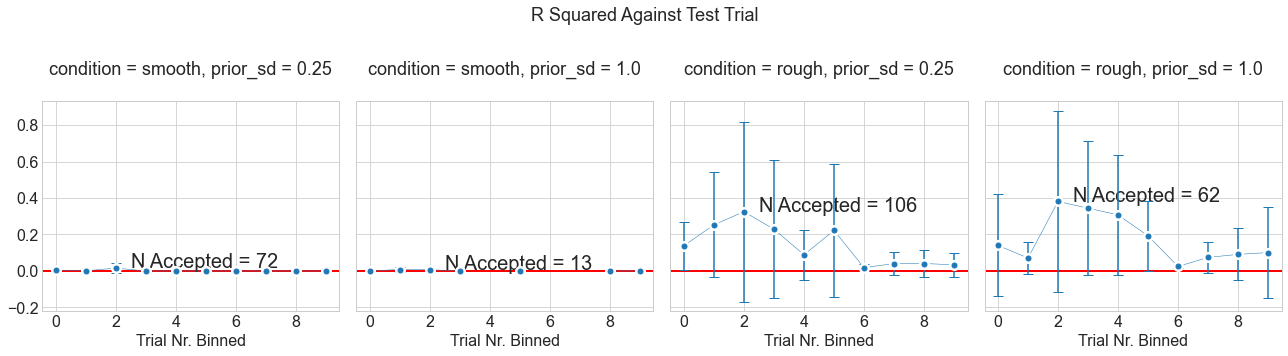

In [62]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharex=True, sharey=True)
plot_uncertainty_over_test_partial = partial(plot_utils.plot_var_over_bintime, var="r_sq")
list(map(plot_uncertainty_over_test_partial, list_dfs_new, l_titles, axes.flatten()))
_ = fig.suptitle("R Squared Against Test Trial\n")
plt.tight_layout()
str_note = "Note. y axes differ between panels"
# _ = plt.figtext(0.99, -0.02, str_note, horizontalalignment='right', size=25)